# The cost of running a bitcoin node
An evidence-based projection

## Motivation
There is a widespread notion in the Bitcoin community that, were blocks allowed
to grow at their natural unconstrained rate, soon the costs of running a fully
validating network node (storing and validating a full copy of the blockchain)
would be out of reach of all but the largest corporations using clusters of
computers so large they could only fit in datacenters. Prominent (and presumably
qualified) technical members of the community have made repeated statements to
this effect. This (among other things, not least of which has been openly censoring
dissenting viewpoints on prominent discussion forums) has done much to sway the
opinions of non-technical members of the community.

The following notebook aims to calculate from available numbers the actual expected
cost of running such a node. It is my sincere hope that, going forward, discussions 
surrounding this topic be based on facts and evidence. Indeed, it is too important
a topic not to employ our analytical capabilities to their fullest.

Cryptocurrency has the potential to improve the lives of millions, if not billions,
of people on this planet if it is allowed to.

While it is by no means necessary for the majority of users to run a fully validating
node, it is important for the health of the network that a broad spectrum of them
be able to do so and choose to do so. Were an attacker (or an aligned coalition of
them) to gain control over **all** full copies of the blockchain **and** over 50% of
the network's hashing power, they would have little problem passing off counterfeit
bitcoin to the rest of the network unnoticed (and thus unpunished by a drop in market
price). Dissuading such an attack requires keeping at least one fully copy of the
blockchain out of the hands of would-be attackers. Strongly dissuading such an attack
means having enough copies in the hands of enough unaligned parties that the expense
involved in "taking out" **all** of them is beyond any potential profit to be gained.

## Scope
I'll be examining two claims about unconstrained block growth, namely that 
it will lead to:
- nodes "only in datacenters", and
- node costs so high only large corporations could afford to run them

I will estimate costs for a fully validating network participant near the edge.
This includes:
- block explorers
- small businesses
- blockchain data service outfits (large and small)
- payment processors (large and small)
- exchanges
- technically inclined enthusiasts
- etc.

I will not be estimating costs for:
- mining farm operators (who may spend more for faster validation)
- those uploading many copies of every block they receive (as more centrally
connected nodes might).

## Calculations
### Block Size
First we must get an idea of what "unconstrained block size growth" means
quantitatively. To study this we must look at the growth in bitcoin's block
size in the years before that growth was constrained by the old 1MB spam limit.

In [1]:
import requests

# grab historical block size data from blockchain.info
r = requests.get('https://api.blockchain.info/charts/avg-block-size?timespan=all&format=csv')

[Text(0,0.5,'Block Size (MB)'), Text(0.5,0,'Date')]

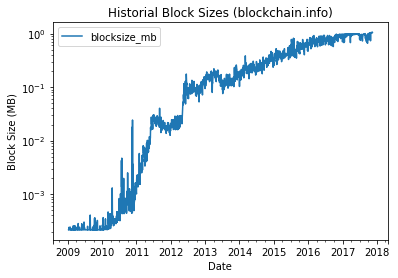

In [248]:
import io

import scipy.optimize
import pandas as pd
import numpy as np

sizes = pd.read_csv(io.StringIO(r.text), header=None,
                    names=('timestamp', 'blocksize_mb'))

# convert timestamp to native timestamps
sizes['timestamp'] = sizes['timestamp'].astype('datetime64[ns]')

# graph sizes for sanity check
%matplotlib inline
ax = sizes.plot(x='timestamp', y='blocksize_mb', logy=True,
                title="Historial Block Sizes (blockchain.info)")
ax.set(ylabel="Block Size (MB)", xlabel="Date")

[Text(0,0.5,'Block Size (MB)'), Text(0.5,0,'Years since Jan 2009')]

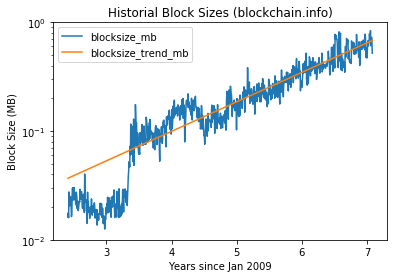

In [249]:
def add_years_column(df):
    """Add a column to the given dataframe for 'years-since-inception'"""
    def to_years(ts):
        return (ts - df.loc[0, 'timestamp']).days / 365
    df['years'] = df['timestamp'].apply(to_years)
    return df

sizes = add_years_column(sizes)

# take a subset from before blocks got full
subset = sizes.query('"2011-06-01" < timestamp < "2016-02-01"').copy()

# fit an exponential trendline to estimate annual growth
def exp_growth(t, a, c):
    return a*np.exp(t/c)

x_data = subset['years']
y_data = subset['blocksize_mb']
popt, pcov = scipy.optimize.curve_fit(exp_growth, x_data, y_data)

def add_blocksize_trend(df):
    """Add a column to the given `df` projecting block size from our
    computed exponential growth model"""
    df['blocksize_trend_mb'] = exp_growth(df['years'], *popt)
    return df

subset = add_blocksize_trend(subset)

# graph that subset
ax = subset.plot(x='years', y='blocksize_mb', logy=True, ylim=(1e-2, 1e0),
                title="Historial Block Sizes (blockchain.info)")
subset.plot(ax=ax, x='years', y='blocksize_trend_mb')
ax.set(ylabel="Block Size (MB)", xlabel="Years since Jan 2009")

In [250]:
# calculate yearly growth (in percent) from our trendline
years = exp_growth([1,2], *popt)
growth = (years[1]/years[0] - 1.0) * 100
print("Yearly growth: {:.1f}%".format(growth))

Yearly growth: 86.8%


In [251]:
df = pd.DataFrame(data={
    'competitor': ['PayPal', 'SWIFT', 'MasterCard', 'VISA', 'Global'],
    'yearly_tx': [1.8e9*4, 29e6*365, 15.2e9*4, 41.8e9*4, 426.3e9]
})

# Sources
# PayPal did 1.8 billion TX in Q4 2016
# http://www.businesswire.com/news/home/20170126006022/en/PayPal-Reports-Fourth-Quarter-Full-Year-2016
# SWIFT peaks at ~29 million transfers per day
# https://www.swift.com/about-us/swift-fin-traffic-figures
# Mastercard did 15.2 billion TX in Q4 2016
# https://newsroom.mastercard.com/press-releases/mastercard-incorporated-reports-fourth-quarter-and-full-year-2016-financial-results/
# VISA did 41.8 billion transactions in Q3 2016
# http://marketrealist.com/2016/12/visa-and-mastercard-see-a-strong-rise-in-transactions-volumes/
# Global digital payments were 426.3 billion TX in 2015 (with 10% annual growth)
# https://globenewswire.com/news-release/2016/09/22/873708/0/en/Global-Digital-Payment-Transactions-Set-to-Reach-10-Percent-Growth-for-First-Time-Finds-World-Payments-Report-2016.html

# some constants we'll use
# https://tradeblock.com/blog/analysis-of-bitcoin-transaction-size-trends
transaction_size_mb = 600.0 / (1024**2)
years_per_second = 1.0 / (365*24*60*60)
seconds_per_block = 10*60

df['avg_tps'] = df['yearly_tx'] * years_per_second
df['blocksize_mb'] = df['avg_tps'] * seconds_per_block * transaction_size_mb
df = df.set_index('competitor')
competitors = df
competitors

,yearly_tx,avg_tps,blocksize_mb
competitor,,,
PayPal,7.200000e+09,228.310502,78.384190
SWIFT,1.058500e+10,335.648148,115.235647
MasterCard,6.080000e+10,1927.955353,661.910941
VISA,1.672000e+11,5301.877220,1820.255088
Global,4.263000e+11,13517.884323,4640.997273


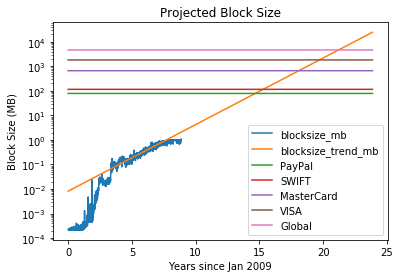

In [252]:
# project out 15 years
years_out = 15
df = sizes.copy()
new_time = pd.DataFrame()
new_time['timestamp'] = pd.date_range(df['timestamp'].max(),
                                      periods=years_out*365/2, freq='2D')
df = add_years_column(df.append(new_time, ignore_index=True))
df = add_blocksize_trend(df)

ax = df.plot(x='years', y='blocksize_mb', logy=True,
             title="Projected Block Size")
df.plot(ax=ax, x='years', y='blocksize_trend_mb')

for competitor in competitors.index:
    df[competitor] = competitors.loc[competitor, 'blocksize_mb']
    df.plot(ax=ax, x='years', y=competitor)

ax.set(ylabel="Block Size (MB)", xlabel="Years since Jan 2009")
future_sizes = df

### Cost of acquiring storage

array([ 0.01809169,  0.08042303,  2.54019397])

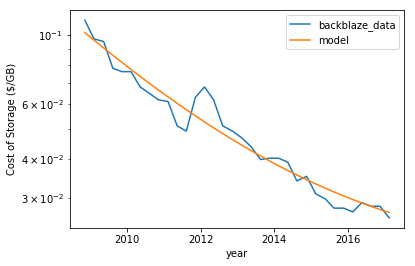

In [256]:
# Costs
# HDD cost trends
# https://www.backblaze.com/blog/hard-drive-cost-per-gigabyte/
# digitized by https://apps.automeris.io/wpd/

df = pd.read_csv(io.StringIO(
"""2008.8587196467993, 0.11147286821705424
2009.1059602649007, 0.09713178294573639
2009.3708609271523, 0.09519379844961236
2009.618101545254, 0.07813953488372088
2009.8653421633555, 0.07620155038759686
2010.1125827814571, 0.07620155038759686
2010.3598233995585, 0.06806201550387593
2010.6070640176602, 0.06496124031007748
2010.8543046357618, 0.06186046511627903
2011.1192052980134, 0.06108527131782944
2011.3664459161148, 0.05100775193798446
2011.6136865342164, 0.04906976744186044
2011.860927152318, 0.06302325581395346
2012.1081677704196, 0.06806201550387593
2012.355408388521, 0.06186046511627903
2012.6026490066226, 0.05100775193798446
2012.8675496688743, 0.04906976744186044
2013.114790286976, 0.04674418604651161
2013.3796909492276, 0.043643410852713144
2013.626931567329, 0.039767441860465075
2013.8741721854306, 0.0401550387596899
2014.1214128035322, 0.0401550387596899
2014.3686534216336, 0.03899224806201548
2014.6158940397352, 0.033953488372093
2014.8807947019868, 0.035116279069767414
2015.1280353200884, 0.03085271317829455
2015.39293598234, 0.029689922480620135
2015.6225165562914, 0.0277519379844961
2015.887417218543, 0.0277519379844961
2016.1346578366447, 0.02697674418604648
2016.3818984547463, 0.028914728682170515
2016.6291390728477, 0.028139534883720896
2016.8763796909493, 0.028139534883720896
2017.123620309051, 0.025813953488372066
"""), names=('year', 'backblaze_data'))

# get the axis to fit our blocksize model start date of Jan, 2009
df['since_09'] = df['year'] - 2009

def exp_decay(t, a, b, c):
    return a + b*np.exp2(-t/c)

x_data = df['since_09']
y_data = df['backblaze_data']
popt, pcov = scipy.optimize.curve_fit(exp_decay, x_data, y_data, )

df['model'] = exp_decay(x_data, *popt)

ax = df.plot(x='year', y='backblaze_data')
df.plot(ax=ax, x='year', y='model', logy=True)
ax.set(ylabel="Cost of Storage ($/GB)")

# add storage cost column to our overall model
future_sizes['storage_cost_per_gb'] = exp_decay(future_sizes.loc[:, 'years'], *popt)

popt

#### Total size of the blockchain

0            0.000000
1            0.000000
2            0.002300
3            0.004608
4            0.006924
5            0.009247
6            0.011579
7            0.013919
8            0.016267
9            0.018623
10           0.020986
11           0.023358
12           0.025739
13           0.028127
14           0.030523
15           0.032928
16           0.035341
17           0.037762
18           0.040192
19           0.042630
20           0.045076
21           0.047530
22           0.049994
23           0.052465
24           0.054945
25           0.057433
26           0.059930
27           0.062436
28           0.064950
29           0.067473
            ...      
4327   1812115.107202
4328   1818330.793178
4329   1824567.799398
4330   1830826.198994
4331   1837106.065345
4332   1843407.472085
4333   1849730.493097
4334   1856075.202521
4335   1862441.674750
4336   1868829.984432
4337   1875240.206469
4338   1881672.416024
4339   1888126.688516
4340   1894603.099621
4341   190

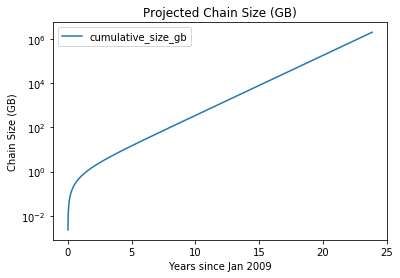

In [317]:
pd.options.display.float_format = '{:.6f}'.format


df = future_sizes
y = df['blocksize_trend_mb']
x = df['timestamp']
mean_y = (y[:-1] + y.shift(-1)[:-1]) / 2
delta_t = (x.shift(-1)[:-1] - x[:-1])
delta_blocks = delta_t * 6/pd.Timedelta("1 hour")

year8 = int(8*365/2)

# calculate additional chain size per time step, scale to GB
scaled_delta_gb = mean_y.multiply(delta_blocks) / 1024

# integrate chain size steps to get total chain size at each time step
df['cumulative_size_gb'] = scaled_delta_gb.cumsum(axis='index').shift(2).fillna(0)
#df['cumulative_size_gb'] = df['cumulative_size_gb'].fillna(0)


# plot for sanity check
ax = df.plot(x='years', y='cumulative_size_gb', logy=True,
             title="Projected Chain Size (GB)")
ax.set(ylabel="Chain Size (GB)", xlabel="Years since Jan 2009")

df['cumulative_size_gb']

In [280]:

# grab real blockchain size data from blockchain.info
r = requests.get('https://api.blockchain.info/charts/blocks-size?timespan=all&format=csv')
blockchain_size = pd.read_csv(io.StringIO(r.text), header=None,
                    names=('timestamp', 'size_mb'))
blockchain_size.

,timestamp,size_mb
0,2009-01-03 00:00:00,0.000000
1,2009-01-05 00:00:00,0.000000
2,2009-01-07 00:00:00,0.000000
3,2009-01-09 00:00:00,0.000000
4,2009-01-11 00:00:00,0.000000
5,2009-01-13 00:00:00,0.000000
6,2009-01-15 00:00:00,0.000000
7,2009-01-17 00:00:00,0.000000
8,2009-01-19 00:00:00,0.000000
9,2009-01-21 00:00:00,0.000000
